In [1]:
import pandas as pd
import requests
import pandahouse as ph
from urllib.parse import urlencode
import seaborn as sns
import matplotlib.pyplot as plt
from operator import attrgetter
import datetime as dt
import plotly.express as px
import numpy as np
from scipy.stats import chi2_contingency, chi2, shapiro, ttest_ind, normaltest, ks_2samp, levene
import pingouin as pg

%matplotlib inline

Задание 1.2

                                         Подготовка данных

Загрузка данных по распределению пользователей по группам

In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key1 = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ' 
 
final_url = base_url + urlencode(dict(public_key=public_key1)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 

download_response = requests.get(download_url) 
groups = pd.read_csv(download_url, sep=';')

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


Загрузка дополнительных данных по распределению пользователей по группам

In [3]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key1 = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ' 
 
final_url = base_url + urlencode(dict(public_key=public_key1)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 

download_response = requests.get(download_url) 
groups_add = pd.read_csv(download_url, sep=',')

Загрузка информации о пользователях, которые использовали платформу в дни проведения эксперимента

In [4]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key1 = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ' 
 
final_url = base_url + urlencode(dict(public_key=public_key1)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 

download_response = requests.get(download_url) 
customers = pd.read_csv(download_url, sep=',')

Загрузка данных об оплатах в дни проведения эксперимента

In [5]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key1 = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA' 
 
final_url = base_url + urlencode(dict(public_key=public_key1)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 

download_response = requests.get(download_url) 
checks = pd.read_csv(download_url, sep=';')

Посмотрим информацию о кол-во пропущенных значений и типы данных в таблицах с распределение пользователей по группам

In [6]:
groups.head(5)

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [7]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [8]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [9]:
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


Проверим есть ли дубликаты в обоих таблицах для нормализации данных

In [10]:
if groups.max()[0] < groups_add.min()[0]:
    print('Нету дубликатов ID в новой таблице')
else:
    print('Есть дубликаты ID в новой таблице')

Нету дубликатов ID в новой таблице


Объединяем два файла с группами

In [11]:
overall_groups = pd.concat([groups, groups_add], axis=0)

Теперь проверяем правильность соединения таблиц. Должно увеличится кол-во строк на величину соответствующую сумме уникальных ID

In [12]:
overall_groups.shape[0] == groups.id.nunique() + groups_add.id.nunique() 

True

Посмотрим на распределение студентов по эксперементальным группам в %

In [13]:
print(str(round(overall_groups.grp.value_counts().A/overall_groups.shape[0] * 100)) + '% в ключевой группе от всех пользователей')
print(str(round(overall_groups.grp.value_counts().B/overall_groups.shape[0] * 100)) + '% в тестовой группе от всех пользователей')
print('Всего пользователей в эксперименте - ' + str(overall_groups.shape[0]))

20% в ключевой группе от всех пользователей
80% в тестовой группе от всех пользователей
Всего пользователей в эксперименте - 74576


Общее количество пользователей в эксперименте и их разбивка по ключевой и тестовой группе может говорить нам о высоком уровне ожидаемого эффекта, значительный масштаб нововведений в механику оплаты или высокой репрезентативности пользователей в выборке группы А

Проверим тип данных и количество пропущенных значений в файле с активными клиентами и клиентами с покупками в дни эксперимента

In [14]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [15]:
customers.head(5)

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [16]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [17]:
checks.head(5)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


Создание объединенной таблицы

Переименуем колонку с ID для слияния таблицы с пользователями по группам для соотнесения с доходами

In [18]:
overall_groups.rename(columns={'id': 'student_id'}, inplace=True)

In [19]:
overall_groups.head(1)

,student_id,grp
0,1489,B


In [20]:
customers_info = overall_groups.merge(checks, on='student_id', how='left')

Проверяем чтобы размер базы ID пользователей не уменьшился

In [21]:
overall_groups.shape[0]-customers_info.shape[0] == 0

True

Заполним отсутствующие значения нулями

In [22]:
customers_info.fillna(0, inplace=True)

Переведём rev в целые значения

In [23]:
customers_info.rev = customers_info.rev.astype(int)

Проверим, чтобы у нас каждый пользователь был распределён по группам

In [24]:
customers_info.grp.unique()

array(['B', 'A'], dtype=object)

                                                   Предобработка данных

Создадим лист для активных клиентов в дни проведения эксперимента

In [25]:
customers_list = customers.student_id.to_list()

In [26]:
customers_list

[581585,
 5723133,
 3276743,
 4238589,
 4475369,
 5481015,
 1353433,
 1394612,
 1170611,
 491277,
 2901778,
 3349200,
 1793347,
 1088622,
 2507615,
 1360026,
 3122918,
 487247,
 4095339,
 1066373,
 639477,
 5194768,
 3658923,
 4169925,
 512868,
 1236043,
 4796033,
 1272447,
 3414514,
 4877802,
 368149,
 4666173,
 2644683,
 4927531,
 1334980,
 3356986,
 478488,
 1388387,
 1116382,
 1238584,
 3213060,
 3443458,
 1806023,
 1294353,
 1136450,
 1485102,
 5678521,
 1418403,
 1338133,
 3490944,
 3505431,
 4741247,
 1063280,
 3540535,
 3207691,
 3557030,
 482241,
 4461974,
 3995792,
 3062394,
 1405187,
 2139033,
 1184303,
 4539466,
 785400,
 4308029,
 2068015,
 3354191,
 1148914,
 1974127,
 681169,
 1133629,
 3489863,
 1622477,
 1189162,
 955477,
 257244,
 3278734,
 1708610,
 4766594,
 3624562,
 496778,
 2309658,
 3553482,
 4624623,
 1238419,
 1963159,
 3149898,
 916134,
 1011517,
 5558980,
 3623841,
 5418281,
 3356931,
 2114824,
 1851185,
 763917,
 359861,
 4369519,
 720651,
 596080,
 532445,

Создадим новую промежуточную колонку чтобы отображать совершил ли студент покупку

In [27]:
customers_info['purchase'] = customers_info.rev.apply(lambda x: True if x != 0 else False)

Добавим отдельную колонку для отображения активности у клиентов

In [28]:
customers_info['is_active'] = customers_info.student_id.apply(lambda x: True if x in customers_list else False)

Посмотрим у скольки клиентов был неактивный статус, хотя они делали покупки и преобразуем число в переменную для сравнения

In [29]:
inactive_buying = customers_info[customers_info.purchase].shape[0] - customers_info[customers_info.is_active & customers_info.purchase].shape[0] 

In [30]:
inactive_buying

149

Исключим данных подобных пользователей из групп, поскольку в данном случае возможен сценарий автооплат, а выборки групп имеют достаточное количество наблюдений для формирования и тестирования гипотез.

In [31]:
customers_info.drop(customers_info.query('is_active == False & purchase == True').index, inplace=True)

Проверим, чтобы мы исключили нужных нам пользователей, поскольку поведение данных студентов может не зависеть от новой механики оплаты и поэтому случайно

In [32]:
customers_info.query('is_active == False & purchase == True')

,student_id,grp,rev,purchase,is_active


Теперь оставим только клиентов которые были активны во время эксперимента, чтобы сравнивать деятельность студентов из разных групп

In [33]:
customers_info = customers_info[customers_info.is_active][['student_id', 'grp', 'rev', 'purchase']]

In [34]:
customers_info.head(5)

,student_id,grp,rev,purchase
1,1627,A,990,True
10,2085,B,0,False
12,2215,B,0,False
43,3391,A,0,False
45,3401,B,0,False


Проверим является ли каждая строка соответствующая ID студента сагрегированной по выручке

In [35]:
if customers_info.shape[0] == customers_info.student_id.nunique():
    print('Каждая строка отражает сагрегированный доход на уникального клиента')
else:
    print('Необходима группировка для отображения дохода на клиента')

Каждая строка отражает сагрегированный доход на уникального клиента


Разделим всех пользователей в отдельные датасеты по группам тестирования для дальнейшего удобства

In [36]:
control_group = customers_info[customers_info.grp == 'A']

In [37]:
control_group.head(5)

,student_id,grp,rev,purchase
1,1627,A,990,True
43,3391,A,0,False
331,109623,A,0,False
614,133678,A,0,False
1002,175944,A,0,False


In [38]:
target_group = customers_info[customers_info.grp == 'B']

Дополнительная проверка все ли клиенты были распределены по группам

In [39]:
control_group.shape[0]+target_group.shape[0] == customers_info.shape[0]

True

Посмотрим как студенты распределились по группам

In [40]:
print(f'''В контрольной группе {str(control_group.shape[0])} активных пользователей.
В целевой группе {str(target_group.shape[0])} активных пользователей''')

В контрольной группе 1538 активных пользователей.
В целевой группе 6803 активных пользователей


Дополнительно удостоверимся, что студенты не находятся одновременно в обоих группах

In [41]:
set(target_group.student_id).intersection(set(control_group.student_id))

set()

Таким образом, мы закончили этап предобработки данных и можем приступать к формированию и тестированию гипотез

                                                  Анализ данных

Посмотрим на параметры доходов у клиентов в группах А и B. В данном случае размеры ключевой и контрольной групп существенно различаются, поэтому необходимо смотреть усреднённые метрики. Также имеет смысл отобрать лишь платящих пользователей для сравнения показателя в обоих группах

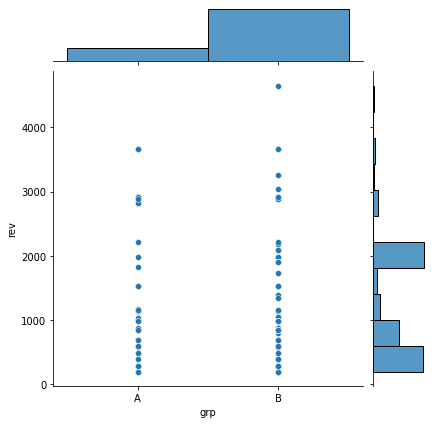

In [42]:
sns.jointplot(x='grp', y='rev', data=customers_info[customers_info.purchase])

In [43]:
target_purchasing = target_group[target_group.purchase]
control_purchasing = control_group[control_group.purchase]

rev_control = control_purchasing.rev.describe()
rev_target = target_purchasing.rev.describe()

rev_control_median = round(rev_control['50%'], 2)
rev_target_median = round(rev_target['50%'], 2)
median_diff = round((rev_target_median/rev_control_median - 1) * 100, 2)

control_rev_std = round(rev_control['std'], 2)
target_rev_std = round(rev_target['std'], 2)
std_diff = round((target_rev_std/control_rev_std - 1) * 100, 2)

In [44]:
print(f'''Медианный доход от клиенту у целевой группы составляет {rev_target_median}, в то время как у контрольной - {rev_control_median}.
Разница между группами B и А в показателе медианного дохода на платящего студента составляет {median_diff}%.
Стандартное отклонение доходов клиентов у целевой группы составляет {target_rev_std}, в то время как у контрольной - {control_rev_std}.
Разница между группами B и А в показателе стандартного отклонения составляет {std_diff}%.''')

Медианный доход от клиенту у целевой группы составляет 1140.0, в то время как у контрольной - 585.0.
Разница между группами B и А в показателе медианного дохода на платящего студента составляет 94.87%.
Стандартное отклонение доходов клиентов у целевой группы составляет 790.86, в то время как у контрольной - 919.93.
Разница между группами B и А в показателе стандартного отклонения составляет -14.03%.


Описательные данные о доходах в группах А и B говорят о наличии сокращения вариативности доходов и увеличении показателя медианных доходов на клиента в целевой группе

Теперь мы можем рассмотреть ключевыем метрики нашего эксперимента по группам: конверсия в покупку, средняя выручка на покупающего пользователя и средняя выручка на студента.

In [45]:
CR_control = control_purchasing.student_id.nunique()/control_group.student_id.nunique()
CR_target = target_purchasing.student_id.nunique()/target_group.student_id.nunique()

ARPPU_control = control_group.rev.sum()/control_purchasing.student_id.nunique()
ARPPU_target = target_group.rev.sum()/target_purchasing.student_id.nunique()

ARPU_control = round(CR_control * ARPPU_control, 2)
ARPU_target = round(CR_target * ARPPU_target, 2)

print(f'''Конверсия в покупку у контрольной группы составляет: {round(CR_control, 3)}
Средняя выручка на покупающего пользователя из контрольной группы составляет: {round(ARPPU_control, 3)}
Средняя выручка на пользователя из контрольной группы составляет: {ARPU_control}


Конверсия в покупку у целевой группы составляет: {round(CR_target, 3)} (изменение на {abs((round(CR_target/CR_control - 1, 2)))*100}%)
Средняя выручка на покупающего пользователя из целевой группы составляет: {round(ARPPU_target, 2)} (изменение на {round((ARPPU_target/ARPPU_control-1)*100, 2)}%)
Средняя выручка на пользователя из целевой группы составляет: {ARPU_target} (изменение на {round((ARPU_target/ARPU_control-1)*100, 2)}%)''')

Конверсия в покупку у контрольной группы составляет: 0.051
Средняя выручка на покупающего пользователя из контрольной группы составляет: 933.59
Средняя выручка на пользователя из контрольной группы составляет: 47.35


Конверсия в покупку у целевой группы составляет: 0.046 (изменение на 9.0%)
Средняя выручка на покупающего пользователя из целевой группы составляет: 1257.88 (изменение на 34.74%)
Средняя выручка на пользователя из целевой группы составляет: 58.06 (изменение на 22.62%)


Таким образом мы можем отметить увеличение показателей метрик целевой группы по сравнению с ключевой на 9% и более, что потенциально может говорить о положительном эффекте от нововведений.

Теперь посмотрим сколько пользователей из общего количества делали покупки во время эксперимента

In [46]:
purchasing_users_A_share = round(control_group.purchase.sum()/control_group.shape[0]*100, 2)
print(f'{purchasing_users_A_share}% пользователей из группы А делали покупки во время эксперимента')
purchasing_users_B_share = round(target_group.purchase.sum()/target_group.shape[0]*100, 2)
print(f'{purchasing_users_B_share}% пользователей из группы B делали покупки во время эксперимента')
print(f'Разница составляет {round(purchasing_users_B_share - purchasing_users_A_share, 2)}%')

5.07% пользователей из группы А делали покупки во время эксперимента
4.62% пользователей из группы B делали покупки во время эксперимента
Разница составляет -0.45%


Проверим количество наблюдений покупающих и не покупающих студентов в группе А и Б в таблице сопряженности

In [47]:
df_crosstab_purchase = pd.crosstab(customers_info.grp, customers_info.purchase)

In [48]:
df_crosstab_purchase

purchase,False,True
grp,,
A,1460,78
B,6489,314


Поскольку мы имеем дело с категориальными переменными, все наблюдения независимы и каждая ячейка содержит более 5 наблюдений, мы можем применить критерий хи-квадрат для проверки гипотезы о наличии стат. значимой разницы в количестве студентов купивших курс.

H0 - группы пользователей не имеют различий в доле покупателей курса среди пользователей
H1 - изменения механики оплаты негативно повлияли на долю покупателей среди пользователей

In [49]:
_, _, stats2 = pg.chi2_independence(customers_info, x='grp', y='purchase')

In [50]:
stats2

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.484808,1.0,0.486252,0.007624,0.107123
1,cressie-read,0.666667,0.482018,1.0,0.487510,0.007602,0.106787
2,log-likelihood,0.000000,0.476541,1.0,0.489993,0.007559,0.106127
3,freeman-tukey,-0.500000,0.472522,1.0,0.491829,0.007527,0.105643
4,mod-log-likelihood,-1.000000,0.468578,1.0,0.493642,0.007495,0.105168
5,neyman,-2.000000,0.460909,1.0,0.497200,0.007434,0.104245


По результам тестов мы видим уровень значимости p порогового значения альфы 0.05 , что позволяет нам принять H0 и отвергнуть H1. Соответственно, у нас недостаточно оснований чтобы говорить о существовании разницы в долях покупающих студентов в группах А и B.

Рассмотрим распределение значений доходов среди клиентов из обоих групп

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


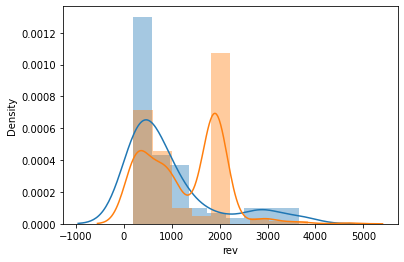

In [51]:
sns.distplot(control_purchasing.rev)
sns.distplot(target_purchasing.rev)

Судя по графику распределений, группа А имеет уномодальное не нормальную форму распределения значений. В то же время, В группа имеет бимодальную не нормальную форму распределения. Оба распределения также скошены влево.

Проверим размеры групп чтобы предварительно оценить мощность выборки

In [52]:
control_purchasing.rev.size

78

In [53]:
target_purchasing.rev.size

314

Дополнительно применим тест для проверки отсутствия нормальности распределений

In [54]:
normaltest(control_purchasing.rev).pvalue <= 0.05

True

In [55]:
normaltest(target_purchasing.rev).pvalue <= 0.05

True

Также, посмотрим на критерий Шапиро-Уиллка, поскольку наши выборки входят в диапазон от 3 до 5000 наблюдейний

In [56]:
shapiro(control_purchasing.rev).pvalue <= 0.05

True

In [57]:
shapiro(target_purchasing.rev).pvalue <= 0.05

True

Таким образом, мы можем утверждать об отсутствии нормальности распределения значений у выборки

Для проверки равенства дисперсий в обоих группах применим критерий Левена с использованием медиан, поскольку наши распределения ассиметричные.

H0 - значения доходов из целевой и ключевой групп относятся к выборкам с одинаковыми дисперсиями;
H1 - доходы от студентов из целевой группы имеют дисперсию стат. значимо отличную от дисперсии данных значений в ключевой группе.

In [58]:
levene(control_purchasing.rev, target_purchasing.rev, center='median').pvalue<=0.05

False

Таким образом, мы должны принять нулевую гипотезу, подтверждая что дисперсии у выборок не имеют статистически значимых различий

Попробуем применить т-тест для проверки равенства средних значений доходов в группах А и B.

К основным требованиям данного теста относятся нормальность распределения средних значений генеральной совокупности и приблизительное равенство дисперсий сравниваемых выборок.

Поскольку данные выборки соответствуют критериям т-теста, мы можем использовать данный тест в качестве основного.

H0 - различий в средних величинах доходов клиентов из разных групп нет.

H1 - покупатели из целевой группы имеют статистически значимые различия средних доходов в сравнении с клиентами из ключевой группы.

In [59]:
pg.ttest(control_purchasing.rev, target_purchasing.rev)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.86169,106.981667,two-sided,0.00507,"[-548.94, -99.64]",0.39646,6.536,0.878211


T-test показывает 152 степеней свободы для данной выборки и уровень p-значимости ниже альфа-значения 0.05. Мы должны принять альтернативную гипотезу в соответствии с данным тестом, подтверждая значимость результата нововведений.

Также проверим распределение доходов в группах с помощью двухвыборочного критерия Колмагорова-Смирнова, чтобы доказать различие в распределении значений в двух выборках.

Критерий Колмагорова-Смирнова предполагает количество наблюдений выше 50-ти в каждой выборке и чувствителен к выбросам в данных.

Н0 - Обе группы клиентов не имеют отличий в распределении доходов.

H1 - Распределение доходов тестовой группы статистически значимо отличается от студентов из ключевой группы.

In [60]:
ks_2samp(control_purchasing.rev, target_purchasing.rev).pvalue<0.05

True

Таким образом, необходимо отвергнуть нулевую гипотезу и принять альтернативную, поскольку значение p в двухвыборочном критерии Колмогорова-Смирнова < порогового значения 0.05

В итоге, мы можем говорить о действительности наличия различия в распределении и средних величинах доходов клиентов из целевой и контрольной групп, в соответствии с результатами t-теста и двухвыборочного теста Колмогорова-Смирнова.

Посмотрим как сдвинулись квантили у значений доходов для ключевой и целевой групп

/opt/tljh/user/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/opt/tljh/user/lib/python3.7/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


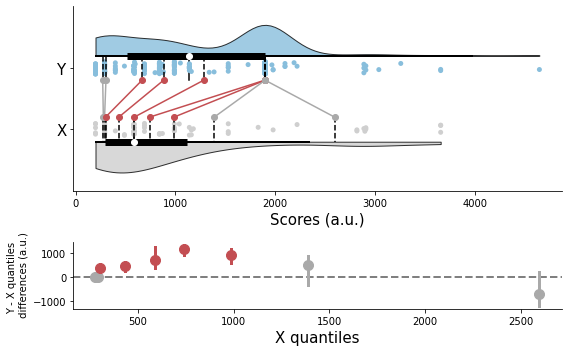

In [61]:
pg.plot_shift(control_purchasing.rev, target_purchasing.rev)
plt.show()

Данный анализ квантилей в обоих группах говорит об изменении медианного сдвига в распределении контрольной группы по сравнению с целевой, а также об уменьшении вариативности квантилей.

Мы также можем оценить как изменились средние значения выручки на студента в тестовой группе по сравнению с контрольной.
Сначала, необходимо равномерно выделить сегменты клиентов по обоим группам в зависимости от значения дохода чтобы сделать возможным применение тестов. 

В нашем случае мы воспользуемся равномерным разделением значений на 4 части через процентили для выделения сегментов студентов.

Для предварительной оценки различия квантилей в контрольной и тестовой группе определим межквартильное значения для распределений.

In [191]:
interquart_control = control_purchasing.rev.describe().loc['75%']-control_purchasing.rev.describe().loc['25%']
interquart_target = target_purchasing.rev.describe().loc['75%']-target_purchasing.rev.describe().loc['25%']
round((interquart_target - interquart_control) / interquart_control * 100, 2)

68.32

Таким образом мы видим отличие межквартильного значения у контрольной и тестовой группы на 68%, что дает целесообразным сравнение средних значений дохода на студента у групп.

Необходимо разделить значения доходов на 4 части ("низкий", "ниже среднего", "выше среднего", "высокий") чтобы выделить средние значения доходов для каждого сегмента.

In [170]:
target_purchasing['rev_category'] = pd.cut(target_purchasing.rev, bins = 4, labels = ['low', 'below average', 'above average', 'high'])

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Посмотрим сколько значений попало в каждый из сегментов и посмотрим на разрыв между самым маленьким и самым большим значением в выборке с другими значениями в их сегменте.

In [171]:
target_purchasing.rev_category.value_counts()

low              160
below average    144
above average      7
high               3
Name: rev_category, dtype: int64

In [205]:
target_purchasing[(target_purchasing.rev_category == 'low') | (target_purchasing.rev_category == 'high')].sort_values('rev').rev.unique()

array([ 199,  290,  398,  489,  580,  590,  597,  690,  796,  840,  870,
        880,  990, 1050, 1140, 1160, 3660, 4650])

Произведём аналогичное сегментирование студентов в контрольной группе

In [208]:
control_purchasing['rev_category'] = pd.cut(control_purchasing.rev, bins = 4, labels = ['low', 'below average', 'above average', 'high'])

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [209]:
control_purchasing.rev_category.value_counts()

low              58
high              9
below average     9
above average     2
Name: rev_category, dtype: int64

In [210]:
control_purchasing[(control_purchasing.rev_category == 'low') | (control_purchasing.rev_category == 'high')].sort_values('rev').rev.unique()

array([ 199,  290,  398,  489,  580,  590,  690,  840,  870,  990, 1039,
       2820, 2890, 2900, 2910, 3660])

Чтобы избежать вероятного смещения значения среднего дохода в группах применим рассчёт медианы к каждому из сегментов клиентов

In [211]:
rev_categories_control = control_purchasing.groupby('rev_category', as_index=False).agg({'rev': 'median'})\
                                            .rename(columns={'rev': "median_rev"})

In [212]:
rev_categories_control

,rev_category,median_rev
0,low,290
1,below average,1180
2,above average,2100
3,high,2910


In [177]:
rev_categories_target = target_purchasing.groupby('rev_category', as_index=False).agg({'rev': 'median'})\
                                            .rename(columns={'rev': "median_rev"})

In [178]:
rev_categories_target

,rev_category,median_rev
0,low,580
1,below average,1900
2,above average,2910
3,high,3660


In [215]:
rev_categories_target.median_rev.describe()

count       4.000000
mean     2262.500000
std      1333.476034
min       580.000000
25%      1570.000000
50%      2405.000000
75%      3097.500000
max      3660.000000
Name: median_rev, dtype: float64

In [216]:
rev_categories_control.median_rev.describe()

count       4.000000
mean     1620.000000
std      1133.872421
min       290.000000
25%       957.500000
50%      1640.000000
75%      2302.500000
max      2910.000000
Name: median_rev, dtype: float64

Для оценки нормальности распределений маленьких размеров (по 4 значения в выборке), применим тест на нормальность с критериями Шапиро-Уилка на распределение медиан в контрольной и целевой группе.

In [213]:
shapiro(rev_categories_target['median_rev']).pvalue <= 0.05

False

In [214]:
shapiro(rev_categories_control['median_rev']).pvalue <= 0.05

False

Значения из обеих выборок нормально распределены в соответствии с критерием Шапиро-Улика, а стандартное отклонение примерно равны друг другу. 

Соответственно, существует возможность применения теста Стьюдента, учитывая выполнения его ключевых требований и маленький размер групп.

In [ ]:
Данный тест проводится для проверки следующих гипотез:
    
Н0 - средние значения медианных доходов у одинаковых сегментов в обоих группах не имеют различий;

H1 - среднее значение медианных доходов у одинаковых сегментов целевой и контрольной группы имеют статистически значимые различия.

In [217]:
pg.ttest(rev_categories_target['median_rev'], rev_categories_control['median_rev'])['p-val'].to_list()[0] <= 0.05

False

Таким образом, необходимо принять Н0 гипотезу и отклонить H1, поскольку тест показал отсутствие достаточных оснований в существовании различий в среднем значении медианы доходов у сегментов студентов между целевой и контрольной группами.

1.3 Задание

1. На какие метрики Вы смотрите в ходе анализа и почему?

В ходе анализа необходимо рассматривались и сравнивались по группам:
- конверсия в покупку;
- средняя выручка на покупающего пользователя;
- средняя выручка на пользователя;
Также сравнивалось распределение доходов от клиентов.

Таким образом, мы сможем определить:
- насколько сильно изменились траты клиентов в различных версиях механики оплаты;
- увеличило ли нововедение конверсию в покупку.

2. Имеются ли различия в показателях и с чем они могут быть связаны?

По сравнению с ключевой группой, активные пользователи из целевой группы имеют следующие изменения:
- Конверсия в покупку увеличилась на 0.005 единиц (9%);
- Средняя выручка на клиента изменилась на 324.29 единиц (изменение на 34.74%);
- Средняя выручка на пользователя изменилась на 10.71 единиц (изменение на 22.62%);
- Медианный доход на пользователя увеличился на 555 единиц (94.87%).

Данные показатели могут говорить о влиянии новой механики оплаты, при отсутствии значимого влияния фактора сезонности продаж.

3. Являются ли эти различия статистически значимыми?

Распределения доходов клиентов из разных групп является статистически значимым в соответствии с критериями Колмогорова-Смирнова (p-value < 0.05).

Более того, t-test в качестве вспомогательного критерия (p-value=0.004732) подтверждает статистическую значимость разницы средних значений доходов от студентов из целевой и ключевой группы.

Также, можно увидеть на графике ниже сдвиг процентилей доходов в разных группах.

/opt/tljh/user/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/opt/tljh/user/lib/python3.7/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


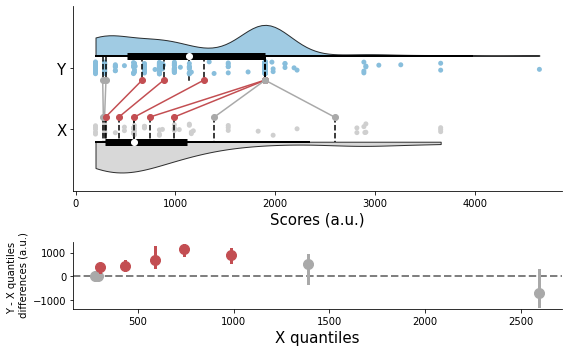

In [66]:
pg.plot_shift(control_purchasing.rev, target_purchasing.rev)
plt.show()

3. Стоит ли запускать новую механику на всех пользователей?

Данную механику стоит запускать на всех пользователей. Для дополнительной уверенности можно провести А/А тест для наблюдения за результатом новведений.